# Prediksi Risiko Stroke

Notebook ini menunjukkan proses pembuatan model machine learning untuk memprediksi risiko stroke berdasarkan dataset kesehatan.

## Dataset

Dataset yang digunakan adalah `healthcare-dataset-stroke-data.csv` yang berisi informasi pasien seperti usia, jenis kelamin, hipertensi, penyakit jantung, dll.

## Langkah-langkah:
1. Memuat dan mengeksplorasi data
2. Preprocessing data (menangani missing values, encoding kategorikal)
3. Membagi data menjadi train dan test
4. Melatih model Random Forest
5. Mengevaluasi model
6. Menyimpan model untuk deployment

In [40]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set style untuk plot
plt.style.use('default')
sns.set_palette('husl')

## 1. Memuat dan Mengeksplorasi Data

In [41]:
# Memuat dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
print("Dimensi dataset:", df.shape)
print("\nInfo dataset:")
df.info()
print("\nStatistik deskriptif:")
df.describe()

Dimensi dataset: (5110, 12)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Statistik deskriptif:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [42]:
# Melihat beberapa baris pertama
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [43]:
# Mengecek missing values
print("Missing values per kolom:")
df.isnull().sum()

Missing values per kolom:


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

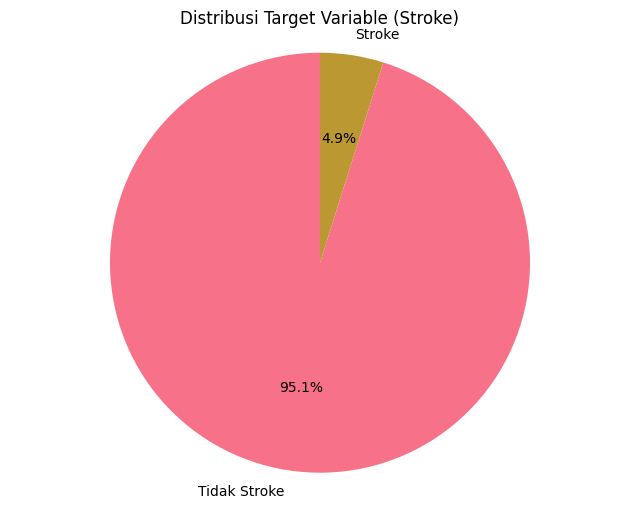

Jumlah kasus stroke: 249
Jumlah kasus tidak stroke: 4861


In [44]:
# Distribusi target variable
plt.figure(figsize=(8, 6))
stroke_counts = df['stroke'].value_counts()
plt.pie(stroke_counts, labels=['Tidak Stroke', 'Stroke'], autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Target Variable (Stroke)')
plt.axis('equal')
plt.show()

print("Jumlah kasus stroke:", stroke_counts[1])
print("Jumlah kasus tidak stroke:", stroke_counts[0])

## 2. Preprocessing Data

In [45]:
# Menghapus kolom 'id' yang tidak diperlukan
df = df.drop('id', axis=1)

# Menangani missing values: mengisi BMI dengan median
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
print("Missing values setelah preprocessing:")
df.isnull().sum()

Missing values setelah preprocessing:


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [46]:
# Encoding variabel kategorikal
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} encoding:")
    for i, class_name in enumerate(le.classes_):
        print(f"  {i}: {class_name}")
    print()

gender encoding:
  0: Female
  1: Male
  2: Other

ever_married encoding:
  0: No
  1: Yes

work_type encoding:
  0: Govt_job
  1: Never_worked
  2: Private
  3: Self-employed
  4: children

Residence_type encoding:
  0: Rural
  1: Urban

smoking_status encoding:
  0: Unknown
  1: formerly smoked
  2: never smoked
  3: smokes



In [47]:
# Memisahkan fitur dan target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Scaling fitur numerik
scaler = StandardScaler()
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("Fitur setelah preprocessing:")
X.head()

Fitur setelah preprocessing:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,1.051434,0,1,1,2,1,2.706375,1.005086,1
1,0,0.786070,0,0,1,3,0,2.121559,-0.098981,2
2,1,1.626390,0,1,1,2,0,-0.005028,0.472536,2
3,0,0.255342,0,0,1,2,1,1.437358,0.719327,3
4,0,1.582163,1,0,1,3,0,1.501184,-0.631531,2


## 3. Membagi Data Train dan Test

In [48]:
# Membagi data dengan stratifikasi untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran training set: {X_train.shape}")
print(f"Ukuran test set: {X_test.shape}")
print(f"Proporsi stroke di training: {y_train.mean():.4f}")
print(f"Proporsi stroke di test: {y_test.mean():.4f}")

Ukuran training set: (4088, 10)
Ukuran test set: (1022, 10)
Proporsi stroke di training: 0.0487
Proporsi stroke di test: 0.0489


## 4. Melatih Model Random Forest

In [49]:
# Membuat dan melatih model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model berhasil dilatih!")
print(f"Jumlah pohon dalam forest: {model.n_estimators}")
print(f"Kedalaman maksimum: {model.max_depth}")

Model berhasil dilatih!
Jumlah pohon dalam forest: 100
Kedalaman maksimum: None


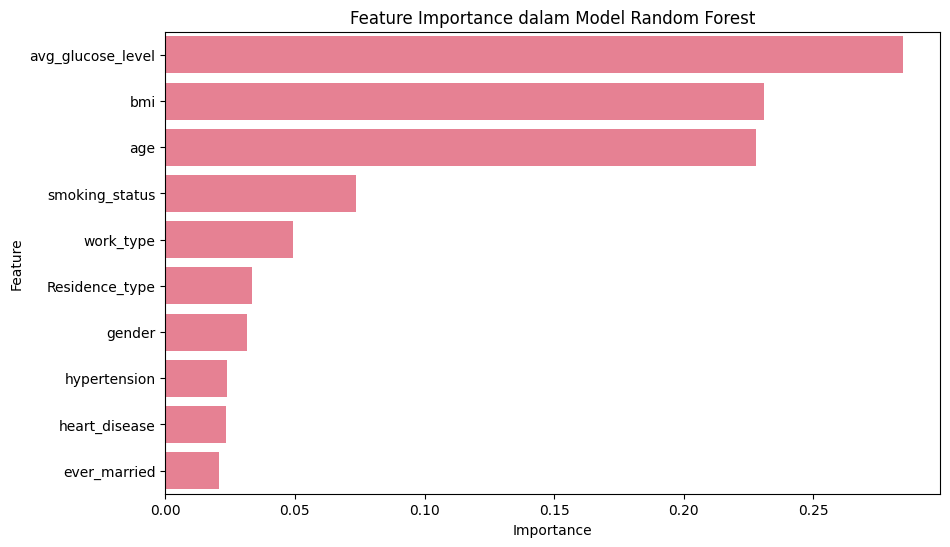

Top 5 fitur terpenting:


,feature,importance
7,avg_glucose_level,0.284699
8,bmi,0.231014
1,age,0.227890
9,smoking_status,0.073687
5,work_type,0.049416


In [50]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance dalam Model Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("Top 5 fitur terpenting:")
feature_importance.head()

## 5. Evaluasi Model

Akurasi: 0.9481
Presisi: 0.2000
Recall: 0.0200
AUC: 0.8160


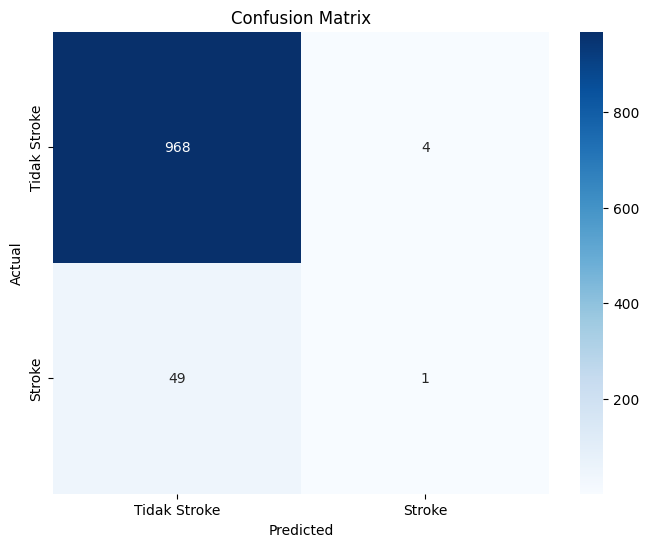

In [51]:
# Prediksi pada test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tidak Stroke', 'Stroke'],
            yticklabels=['Tidak Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 6. Menyimpan Model

In [52]:
# Menyimpan model, scaler, dan label encoders
joblib.dump(model, 'stroke_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("Model, scaler, dan label encoders berhasil disimpan!")
print("File yang disimpan:")
print("- stroke_model.pkl")
print("- scaler.pkl")
print("- label_encoders.pkl")

Model, scaler, dan label encoders berhasil disimpan!
File yang disimpan:
- stroke_model.pkl
- scaler.pkl
- label_encoders.pkl


## Kesimpulan

Model Random Forest telah berhasil dibuat untuk memprediksi risiko stroke dengan performa sebagai berikut:

- **Akurasi**: {:.4f}
- **Presisi**: {:.4f}
- **Recall**: {:.4f}
- **AUC**: {:.4f}

Fitur terpenting dalam model adalah usia, kadar glukosa rata-rata, dan BMI.

Model ini dapat digunakan untuk aplikasi Streamlit yang telah dibuat sebelumnya.